<a href="https://colab.research.google.com/github/kaispace30098/Tensorflow_Object_Detection/blob/main/SSD_Tensorflow_object_detection_on_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: This notebook is edited from Lazy Programmer, the instructor of Deep Learning: Advanced Computer Vision for learning and experimental use only.

In [3]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 72218, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 72218 (delta 14), reused 36 (delta 14), pack-reused 72179
Receiving objects: 100% (72218/72218), 578.97 MiB | 30.82 MiB/s, done.
Resolving deltas: 100% (51065/51065), done.


In [4]:
#Protocol Buffers(protobuf): serialize or deseiralize objects into any language:
#We may convert python obects into 01 patterns and reload it to C++


In [5]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

install object detection api

In [6]:
!cd models/research &&\
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.2 MB 9.0 MB/s 
     |████████████████████████████████| 352 kB 70.6 MB/s 
     |████████████████████████████████| 2.2 MB 57.1 MB/s 
     |████████████████████████████████| 23.4 MB 95.8 MB/s 
     |████████████████████████████████| 90 kB 12.9 MB/s 
     |████████████████████████████████| 99 kB 12.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.5 MB/s 
     |████████████████████████████████| 636 kB 55.2 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 51

In [7]:
!cd models/research && python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-04-27 04:30:19.922693: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0427 04:30:20.179749 140222275282816 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.73s
I0427 04:30:20.529163 140222275282816 test_util.py:2374] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 2.73s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.48s
I0427 04:30:21.009954 140222275282816 test

In [8]:
import os
import imageio
import pathlib
import tensorflow as tf

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

# Enable GPU dynamic memory allocation

In [9]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

#Download the model file

In [14]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8',
    origin=url,
    untar=True)

386539520/386527459 [==============================] - 1s 0us/step


In [15]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

#Download labels file

In [16]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(
    fname='mscoco_label_map.pbtxt',
    origin=url,
    untar=False)

16384/5056 [=================================================================================================] - 0s 0us/step


In [17]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [18]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


In [19]:
#LOAD the model
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 27.130874395370483 seconds


In [20]:
#Load the labels

In [21]:
category_index = label_map_util.create_category_index_from_labelmap(
    PATH_TO_LABELS,
    use_display_name=True)

In [22]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [23]:
## Helper function

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [24]:
def detect_objects(image_path):
    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Do the detection
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # show classes
    # unique_classes = set(detections['detection_classes'])
    # print("Classes found:")
    # for c in unique_classes:
    #     print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

Running inference for 93064471.png... Done


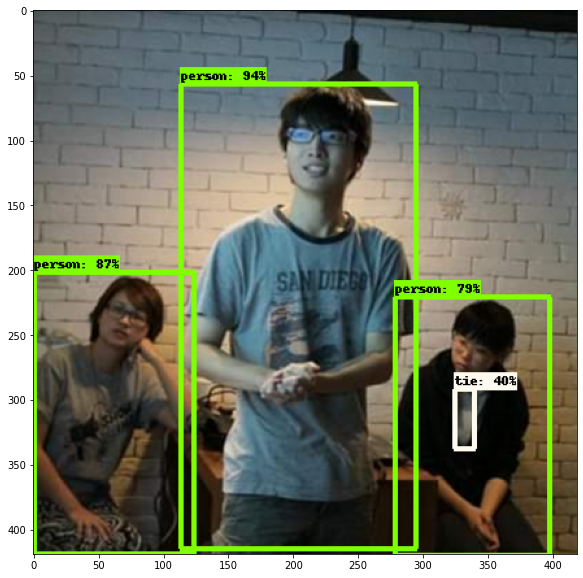

In [30]:
detect_objects('93064471.png')

Running inference for /content/traffic.jpeg... Done


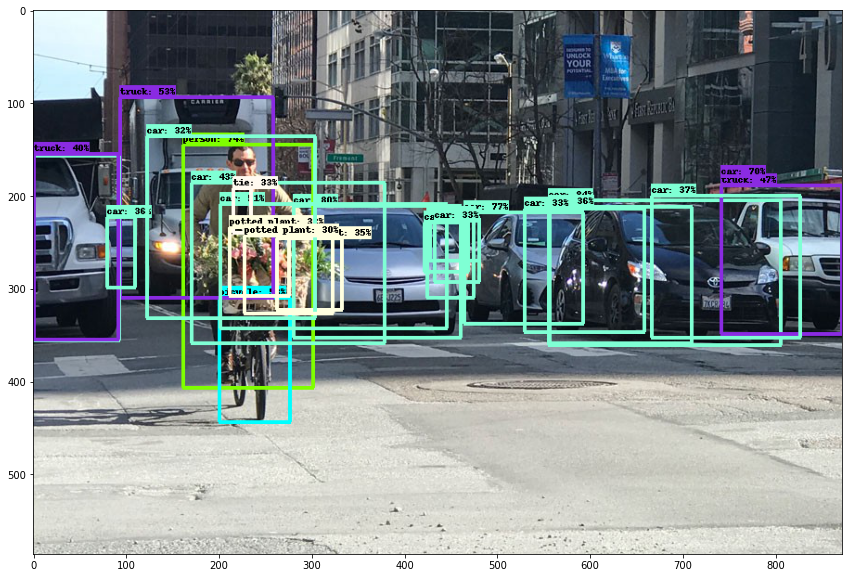

In [31]:
detect_objects('/content/traffic.jpeg')